# Mini Project 4

**2025 Introduction to Quantiative Methods in Finance**

**The Erdös Institute**

In the lectures we explored how to delta hedge sold call options, resulting in a trading strategy whose profits are neutral to upward or downward drift in a stock path movements, provided the volatility, or $\sigma$, of the stock remained constant.

For this final mini project explore the impact of a non-constant $\sigma$ on the distribution of profits of hedging. You are also encouraged to explore/research a $\sigma$-hedging strategy and write code that simulates the profit distribution of the $\sigma$-hedging strategy. 

Below is some code you can customize that simulates a stock path whose $\sigma$ is not constant.

You are encouraged to use a different model for sigma than the one provided. You can use stock paths simulated by Heston model? You could use a GARCH model for volatility. The choice is yours and you can do your own research to choose how to model a stock movement. 

In [122]:
#Package Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import yfinance as yf
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import shapiro
import scipy.stats as stats
from scipy.optimize import brentq
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import quad
from scipy.optimize import minimize
from joblib import Parallel, delayed
from scipy.stats import rv_discrete
from statsmodels.stats.diagnostic import acorr_ljungbox
from functions import *
from dateutil import parser
from dateutil.tz import tzutc
import datetime
import yfinance as yf
import pandas as pd
from tqdm import tqdm

sns.set_style('darkgrid')

In [123]:
def stock_path_custom_sigma(S0, t, r, mu, n_paths, n_steps):
    '''
    Generation of custom stock paths following Geometeric Brownian motion,
    but log-returns do not have constant volatility.
    
    Each step of the log-returns, there is a 
    1) 50% the volatility is .2
    2) 30% chance the volatility is .3
    3) 20% chance the volatility is .45
    
    Inputs:
    S0 (float): initial stock value
    t (float): time interval of stock path movements in years
    r (float): risk-free interest rate
    mu (float): drift of log-returns
    n_paths (int): number of stock paths
    n_steps (float): number of steps in each stock path
    
    Returns:
    
    Simuatled stock paths
    '''
    
    #Noise in volatility
    noise = np.random.normal(0,1,size = (n_paths, n_steps))
    
    #Custom sigma that is not constant
    sigma = np.random.choice([.2,.3,.45], p = [.5, .3, .2], size = (n_paths, n_steps))
    
    #Time increment between each step
    dt = t/n_steps
    
    #log-returns between each step
    increments = (mu + r - .5*sigma**2)*dt + sigma*np.sqrt(dt)*noise
    
    #Cumulative log-returns at each step
    log_returns = np.cumsum(increments, axis = 1)
    
    
    #paths
    paths = S0*np.exp(log_returns)
    
    
    #Adjoint initial value S0 at start of each simulated path
    paths = np.insert(paths, 0, S0, axis = 1)
    
    
    return paths
    
    

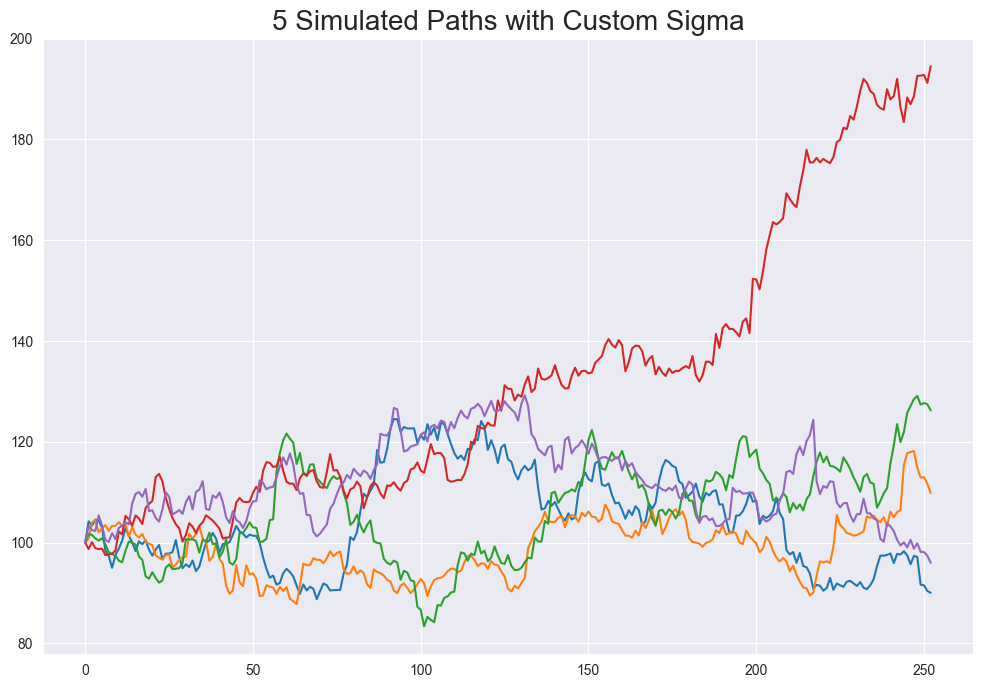

In [124]:
#5 Simulated paths of daily steps over 1-year period and plot

S0 = 100
t = 1
r = 0.039
mu = 0.275
n_paths = 5
n_steps = 252


simulated_paths = stock_path_custom_sigma(S0, t, r, mu, n_paths, n_steps)


plt.figure(figsize = (12,8))

for path in simulated_paths:
    plt.plot(path)
    
plt.title(f'{n_paths} Simulated Paths with Custom Sigma', size = 20)


plt.show()

In [125]:
##Functions for option data obtained through y-finance

from dateutil import parser
from dateutil.tz import tzutc

def find_tte_yf_options(expiration_date,last_trade_date):
    '''returns time measured in years as a float between two dates
    
    Inputs:
    expiration_date (str): 'YYYY-MM-DD'
    last_trade_date (pandas._libs.tslibs.timestamps.Timestamp)
    
    Returns:
    Float of time to expiration in years
    '''
    tte = (datetime.datetime.strptime(expiration_date+'-21-30', "%Y-%m-%d-%H-%M").replace(tzinfo=tzutc()) -\
last_trade_date).total_seconds()/(60*60*24*365)
    
    return tte


In [126]:
# Fix timezone and date alignment
def yf_find_approx_spot(stock_data, last_trade_date):
    """
    Match last_trade_date to a daily close price (timezone-naive).
    """
    try:
        naive_date = last_trade_date.tz_convert(None).normalize()
        return stock_data.loc[naive_date]
    except Exception:
        return float('nan')


# Helper: time to expiration in years
def find_tte_yf_options(expiration_date, last_trade_date):
    tte = (
        datetime.datetime.strptime(expiration_date + '-21-30', "%Y-%m-%d-%H-%M")
        .replace(tzinfo=tzutc()) - last_trade_date
    ).total_seconds() / (60 * 60 * 24 * 365)
    return tte


# Main preprocessing function
def preprocessing(stock_symbol):
    ticker = yf.Ticker(stock_symbol)

    # Download 252 days of daily spot prices (1 year)
    stock_data = yf.download(stock_symbol, period='252d', interval='1d')
    stock_data.index = stock_data.index.tz_localize(None)  # remove timezone
    spot_series = stock_data['Close']

    expirations = ticker.options
    option_data = []

    # Collect all available call and put option chains
    for date in expirations:
        try:
            chain = ticker.option_chain(date)
        except Exception:
            continue

        calls = chain.calls.copy()
        calls['expiration'] = date
        calls['option_type'] = 'call'

        puts = chain.puts.copy()
        puts['expiration'] = date
        puts['option_type'] = 'put'

        option_data.append(calls)
        option_data.append(puts)

    options_data = pd.concat(option_data, ignore_index=True)
    options_data = options_data.drop(columns=['impliedVolatility'], errors='ignore')

    # Filter out options with last trade before our stock data
    start_date = stock_data.index[0]
    options_data = options_data[options_data['lastTradeDate'] >= pd.Timestamp(start_date).tz_localize('UTC')]

    # Compute time to expiration
    options_data['time_to_expiration'] = options_data.apply(
        lambda row: find_tte_yf_options(row['expiration'], row['lastTradeDate']),
        axis=1
    )

    # Approximate spot price from daily close prices
    options_data['spot_price'] = options_data.apply(
        lambda row: yf_find_approx_spot(spot_series, row['lastTradeDate']),
        axis=1
    )
    options_data = options_data.dropna()

    # Keep relevant columns and split by call/put
    options_data = options_data[['strike', 'lastPrice', 'lastTradeDate',
                                 'expiration', 'option_type', 'time_to_expiration', 'spot_price']]
    options_data_calls = options_data[options_data['option_type'] == 'call'].copy()
    options_data_puts = options_data[options_data['option_type'] == 'put'].copy()

    # Compute implied volatility
    r = 0.039
    options_data_calls['implied_volatility'] = options_data_calls.apply(
        lambda row: implied_volatility_call(
            market_price=row['lastPrice'],
            S0=row['spot_price'],
            K=row['strike'],
            t=row['time_to_expiration'],
            r=r
        ),
        axis=1
    )
    options_data_puts['implied_volatility'] = options_data_puts.apply(
        lambda row: implied_volatility_put(
            market_price=row['lastPrice'],
            S0=row['spot_price'],
            K=row['strike'],
            t=row['time_to_expiration'],
            r=r
        ),
        axis=1
    )

    # Drop NaNs and keep contracts with 0.5 to 1 year maturity
    options_data_calls = options_data_calls.dropna()
    options_data_puts = options_data_puts.dropna()

    options_data_calls = options_data_calls[
        (options_data_calls['time_to_expiration'] <= 1) & (options_data_calls['time_to_expiration'] >= 0.5)
    ]
    options_data_puts = options_data_puts[
        (options_data_puts['time_to_expiration'] <= 1) & (options_data_puts['time_to_expiration'] >= 0.5)
    ]

    return options_data_calls, options_data_puts

In [127]:
# I combined the code from the lecture into this single function. This function calibrate Heston model to option data using gradient descent.
def calibrate_call(options_data_calls):

    def objective(params, option_data, r):
        kappa, theta, xi, rho, v0 = params

        if len(option_data) == 0:
            return 1e10  # large penalty if input is empty

        error = 0
        for _, row in option_data.iterrows():
            model_price = heston_call(
                S0=row['spot_price'],
                K=row['strike'],
                v0=v0,
                r=r,
                t=row['time_to_expiration'],
                kappa=kappa,
                theta=theta,
                xi=xi,
                rho=rho
            )
            market_price = row['lastPrice']
            error += (model_price - market_price) ** 2

        return error / len(option_data)


    initial_guess = [1.0, 0.04, 0.3, -0.5, 0.04]  # kappa, theta, xi, rho, v0
    bounds = [(1e-4, 10), (1e-4, 1), (1e-4, 2), (-0.99, 0.99), (1e-4, 1)] 


    r = 0.039  

    result = minimize(
        objective,
        initial_guess,
        args=(options_data_calls, r),
        bounds=bounds,
        method='L-BFGS-B',
        options={
            'disp': True,
            'maxiter': 20,       
            'ftol': 1e-4,         
            'gtol': 1e-4          
        }
    )


    calibrated_params = result.x

    return calibrated_params

In [128]:
def run_heston_delta_vega_hedge(
    target_call,
    hedge_call,
    v0,
    kappa,
    theta,
    xi,
    rho,
    mu=0.0,
    n_sims=1000,
    hedge_freq=52,
    r=0.039,
    inflation_const=2.0
):
    """
    Delta+vega hedge under Heston model using Black-Scholes Greeks,
    with a self-financing cash account (no Heston-Greek fallback).
    """

    # 1) extract option data
    if target_call.expiration != hedge_call.expiration:
        raise ValueError("Target and hedge calls must share the same expiration")
    

    desk_vol0 = float(target_call.get('implied_volatility', np.sqrt(v0)))  # fallback to sqrt(v0)
    desk_vol0 = max(desk_vol0, 1e-6)
    desk_vol0 *= inflation_const 
    sigma_filt = np.full(n_sims, desk_vol0, dtype=float)

    S0       = float(target_call.spot_price)
    K_target = float(target_call.strike)
    T        = float(target_call.time_to_expiration)
    K_hedge  = float(hedge_call.strike)

    # 2) time grid
    n_steps = max(1, int(hedge_freq * T))
    dt      = T / n_steps

    # 3) simulate Heston paths
    paths, variances = heston_path_sim(
        S0, v0, r, T, n_steps, kappa, theta, xi, rho,
        n_sims, mu, return_vol=True
    )

    # 4) initial BS Greeks
    sigma0        = np.sqrt(v0)
    delta_T0      = bs_call_delta(S0, K_target, desk_vol0 * sigma0, T, r)
    vega_T0       = bs_vega(S0,   K_target, desk_vol0, T, r)
    delta_H0      = bs_call_delta(S0, K_hedge,  desk_vol0, T, r)
    vega_H0       = bs_vega(S0,   K_hedge,  desk_vol0, T, r)
    eps_vega      = 1e-2
    vega_H0       = max(vega_H0, eps_vega)

    w_h = vega_T0 / vega_H0
    w_s = delta_T0 - w_h * delta_H0

    # 5) initial replication error check
    price_hedge0       = bs_call(S0, K_hedge,  desk_vol0, T, r)
    initial_call_price = bs_call(S0, K_target, desk_vol0, T, r)
    initial_cash = initial_call_price - (w_s * S0 + w_h * price_hedge0)
    print(f"[initial cash to match price] = {initial_cash:.6f}")

    # 6) set up self-financing cash account
    cash = initial_call_price - (w_s * S0 + w_h * price_hedge0)

    # 7) dynamic hedging (exclude final time step)
    eps_sigma = 1e-3
    alpha = 0.1

    for i in tqdm(range(1, n_steps)):
        # 7a) accrue interest on cash from t_{i-1} to t_i
        cash *= np.exp(r * dt)

        # 7b) current state
        t_now   = i * dt
        tau     = max(T - t_now, eps_sigma)
        S_i     = paths[:, i]
        sigma_i = np.sqrt(variances[:, i]).clip(min=eps_sigma)

        prev_sigma = inflation_const * np.sqrt(np.maximum(variances[:, i-1], 0.0))
        sigma_filt = alpha * prev_sigma + (1.0 - alpha)*sigma_filt
        vol_i      = np.maximum(sigma_filt, 1e-6)

        # 7c) compute new BS Greeks
        delta_Ti = bs_call_delta(S_i, K_target, vol_i, tau, r)
        vega_Ti  = bs_vega(S_i,   K_target, vol_i, tau, r)
        delta_Hi = bs_call_delta(S_i, K_hedge,  vol_i, tau, r)
        vega_Hi  = np.maximum(bs_vega(S_i,   K_hedge,  vol_i, tau, r),
                              eps_vega)

        # 7d) new weights
        w_h_new = vega_Ti / vega_Hi
        w_s_new = delta_Ti - w_h_new * delta_Hi

        # 7e) trades executed (self-financing)
        dW_s = w_s_new - w_s
        dW_h = w_h_new - w_h
        price_hedge_i = bs_call(S_i, K_hedge, vol_i, tau, r)

        # subtract cost of trades from cash
        cash += - dW_s * S_i - dW_h * price_hedge_i

        # 7f) update weights
        w_s, w_h = w_s_new, w_h_new

    # 8) final accrual to T
    cash *= np.exp(r * dt)

    # 9) liquidation at T
    S_T          = paths[:, -1]
    payoff_Hedge = np.maximum(S_T - K_hedge, 0)
    payoff_Target= np.maximum(S_T - K_target,0)

    cash += w_s * S_T                # unwind stock
    cash += w_h * payoff_Hedge       # unwind hedge option
    cash += - payoff_Target          # settle short target option

    # 'cash' now represents the total P&L (self-financing)
    return cash

In [129]:
# Let us play with apple

In [130]:
# Step 1: preprocess the data
calls, puts = preprocessing("AAPL")

/var/folders/9x/4tkzr1yj0h5cbcc06nsykx7w0000gn/T/ipykernel_4316/1328212634.py:27: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(stock_symbol, period='252d', interval='1d')
[*********************100%***********************]  1 of 1 completed


In [131]:
# Let's take a look!
calls.head(5)

,strike,lastPrice,lastTradeDate,expiration,option_type,time_to_expiration,spot_price,implied_volatility
629,45.0,156.95,2025-05-28 16:46:46+00:00,2025-12-19,call,0.562183,200.192795,1.063936
901,105.0,111.38,2025-07-03 16:53:59+00:00,2026-02-20,call,0.636142,213.307922,0.466833
992,90.0,151.40,2025-09-08 13:30:04+00:00,2026-03-20,call,0.529680,237.880005,0.820857
995,105.0,126.00,2025-08-11 16:03:44+00:00,2026-03-20,call,0.606100,227.179993,0.608914
997,115.0,116.06,2025-08-11 17:29:35+00:00,2026-03-20,call,0.605937,227.179993,0.532603


In [132]:
# This function finds a good target call option and a good hedge option
def select_target_and_hedge(calls_df):
    """
    Returns (target_call, hedge_call) as two pd.Series.
    """
    df = calls_df.copy()
    df['expiration'] = pd.to_datetime(df['expiration'])
    
    # Front‐month
    front = df['expiration'].min()
    df_fm = df[df['expiration'] == front].copy()
    
    # Spot
    spot = df_fm['spot_price'].iloc[0]
    
    # ATM for hedge
    df_fm['dist_to_spot'] = (df_fm['strike'] - spot).abs()
    idx_hedge = df_fm['dist_to_spot'].idxmin()
    
    # Nearest OTM (else nearest ITM) for target
    otm = df_fm[df_fm['strike'] > spot]
    if not otm.empty:
        target_strike = otm['strike'].min()
    else:
        itm = df_fm[df_fm['strike'] < spot]
        target_strike = itm['strike'].max()
    idx_target = df_fm[df_fm['strike'] == target_strike].index[0]
    
    # Extract and clean
    hedge_call  = df_fm.loc[idx_hedge].drop('dist_to_spot')
    target_call = df_fm.loc[idx_target].drop('dist_to_spot')
    
    return target_call, hedge_call

In [133]:
# Find the suitable target and hedge call
target_call, hedge_call = select_target_and_hedge(calls)

In [134]:
# Pull in the preprocessed calls table
calls, _ = preprocessing("AAPL")

# Here I pick calls with the earliest (front‐month) expiration to calibrate
front_exp = calls['expiration'].min()

# Filter your DataFrame to that single expiration
calls_fm = calls[calls['expiration'] == front_exp].copy()

# Further restrict to strikes near spot
spot = calls_fm['spot_price'].iloc[0]
calls_fm = calls_fm[
    calls_fm['strike'].between(0.8*spot, 1.2*spot)
]

/var/folders/9x/4tkzr1yj0h5cbcc06nsykx7w0000gn/T/ipykernel_4316/1328212634.py:27: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(stock_symbol, period='252d', interval='1d')
[*********************100%***********************]  1 of 1 completed


In [135]:
# Now we calibrate the Heston model
heston_para = calibrate_call(calls_fm)

In [136]:
# Unpack the parameters, order: kappa, theta, xi, rho, v0
kappa, theta, xi, rho, v0 = heston_para

In [137]:
print(heston_para)

[ 1.    0.04  0.3  -0.5   0.04]


In [138]:
# Now we are ready to simlate and test our hedging strategy.
res = run_heston_delta_vega_hedge(
    target_call,
    hedge_call,
    v0,
    kappa,
    theta,
    xi,
    rho,
    mu=0.0,
    n_sims=1000,
    r=0.039
)

[initial cash to match price] = -8.071172


100%|██████████| 28/28 [00:00<00:00, 3798.57it/s]


In [139]:
res.mean()

np.float64(0.0010323516657985295)

In [140]:
res.std()

np.float64(0.2186647141012345)

In [141]:
def run_heston_no_hedge(
    target_call,
    v0,
    kappa,
    theta,
    xi,
    rho,
    mu=0.0,
    n_sims=1000,
    n_steps=50,
    r=0.039,
    inflation_const=2.0
):
    """
    P&L for unhedged short call position under Heston model.
    """
    # Spot, strike, maturity
    S0 = float(target_call.spot_price)
    K_target = float(target_call.strike)
    T = float(target_call.time_to_expiration)

    # Simulate Heston paths
    paths, _ = heston_path_sim(
        S0, v0, r, T, n_steps, kappa, theta, xi, rho, n_sims, mu, return_vol=True
    )

    # Payoff of target call at maturity
    S_T = paths[:, -1]
    payoff_target = np.maximum(S_T - K_target, 0)
    discount_T = np.exp(-r * T)

    # Initial premium received (use BS pricing)
    initial_call_price = bs_call(S0, K_target, inflation_const * np.sqrt(v0), T, r)

    # Since you're short the option, P&L is:
    total_pnl = -payoff_target + initial_call_price / discount_T

    return total_pnl

In [142]:

unhedged_pnl = run_heston_no_hedge(target_call,
    v0,
    kappa,
    theta,
    xi,
    rho,
    mu=0.0,
    n_sims=1000,
    n_steps=50,
    r=0.039)

print("Unhedged - Mean:", np.mean(unhedged_pnl), "Variance:", np.var(unhedged_pnl))

Unhedged - Mean: -0.41607874346846846 Variance: 894.5229066450095


In [143]:
print(f'hedged mean: {res.mean()}, hedged max: {res.max()}, hedged min: {res.min()}, hedged std: {res.std()}')
print(f'unhedged mean: {unhedged_pnl.mean()}, unhedged max: {unhedged_pnl.max()}, unhedged min: {unhedged_pnl.min()}, unhedged std: {unhedged_pnl.std()}')

hedged mean: 0.0010323516657985295, hedged max: 0.750380135342084, hedged min: -0.6757675003283623, hedged std: 0.2186647141012345
unhedged mean: -0.41607874346846846, unhedged max: 104.86250000706653, unhedged min: -110.82436802619671, unhedged std: 29.908575804357678
